In [4]:
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os 

rlpath = Path("/content").absolute()
ckpath = Path("/content").absolute()
DEVICE = "cuda"

plt.rcParams["savefig.bbox"] = 'tight'

In [5]:
def read_images(paths, extension=None) -> list[Image]:
    images = []
    for path in paths:
        fname = f"{path}.{extension}" if extension else str(path)
        img = Image.open(fname)
        images.append(img)
    return images

def get_fnames_without_extension(directory_path: Path):
    file_names = []

    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)):
            name, extension = os.path.splitext(filename)
            if name[0] != ".":
                file_names.append(name)
    
    return file_names


# Faces

In [6]:
names = set(get_fnames_without_extension(rlpath))
rl_images_paths = [rlpath / name for name in names]
ck_images_paths = [ckpath / name for name in names]

ck_images = read_images(list(ck_images_paths), "png")
rl_images = read_images(list(rl_images_paths), "jpeg")

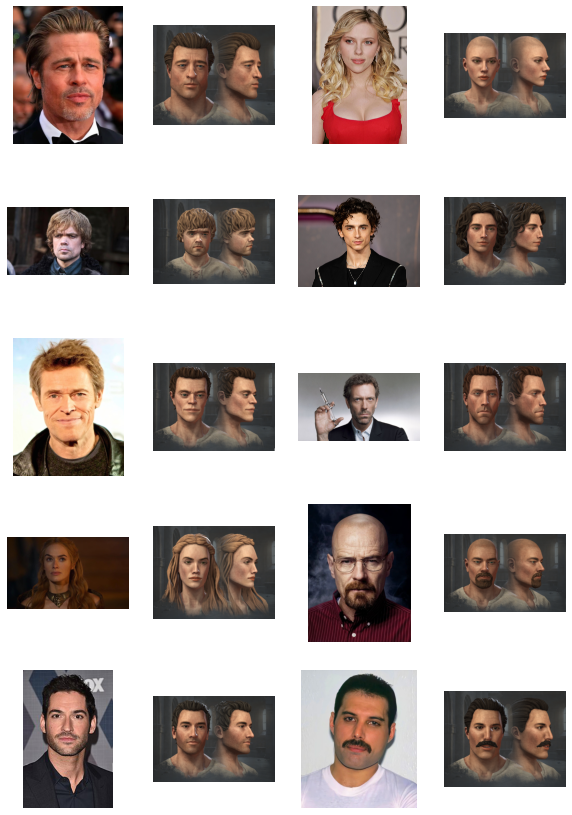

In [7]:
plt.figure(figsize=(10, 30))
for i, (rl_img, ck_img) in enumerate(zip(rl_images, ck_images)):
    plt.subplot(len(names), 4, 2*i + 1)
    plt.axis("off")
    plt.imshow(rl_img)
    plt.subplot(len(names), 4, 2*i + 2)
    plt.axis("off")
    plt.imshow(ck_img)

In [ ]:
from deepface import DeepFace
from pathlib import Path 
import pickle 

model_names = [
    "VGG-Face",
    "OpenFace",
    "Facenet",
    "Facenet512",
    "DeepFace",
    "DeepID",
    "Dlib",
    "ArcFace",
    "SFace",
]

def get_embeddings(images_paths, model_name):
    embeddings = {}
    for path in images_paths:
        emb = DeepFace.represent(
            str(path), 
            model_name=model_name, 
            detector_backend="mtcnn", 
            normalization="Facenet"
        )[0]
        embeddings[path.name] = emb
    return embeddings

ck_dir = Path() 
rl_dir = Path()

model2dirs = {}
for model in model_names:
    dir2embeddings = {}
    for path in rl_dir.iterdir():
        if not path.is_dir():
            continue
        rl_emb = get_embeddings(list(path.glob("*.jpg")), model)
        dir2embeddings[path.name] = rl_emb
    ck_emb = get_embeddings(list(ck_dir.glob("*.png")), model)
    dir2embeddings["ck"] = ck_emb
    
    model2dirs[model] = dir2embeddings


with open("embeddings.pickle", "wb") as f:
    pickle.dump(model2dirs, f)

In [ ]:
from deepface import DeepFace
import tensorflow as tf 
import seaborn as sns


def get_embeddings(images_paths, model_name):
    embeddings = {}
    for path in images_paths:
        emb = DeepFace.represent(
            str(path), 
            model_name=model_name, 
            detector_backend="mtcnn", 
            normalization="Facenet"
        )[0]
        embeddings[path.name] = emb
    return embeddings


model_names = [
    "VGG-Face",
    "OpenFace",
    "Facenet",
    "Facenet512",
    "DeepFace",
    "DeepID",
    "Dlib",
    "ArcFace",
    "SFace",
]


embeddings = {}

for model in model_names:
    ck_embeddings = []
    rl_embeddings = []

    for ck_path, rl_path in zip(ck_images_paths, rl_images_paths):
        ck_embeddings.append(DeepFace.represent(str(ck_path) + ".png", model_name=model, detector_backend="mtcnn", normalization="Facenet")[0]["embedding"])
        rl_embeddings.append(DeepFace.represent(str(rl_path) + ".jpeg", model_name=model, detector_backend="mtcnn", normalization="Facenet")[0]["embedding"])
    
    real_names = [n + "_real" for n in names]
    ck_names = [n + "_ck" for n in names]
    ck_embeddings = tf.stack(ck_embeddings)
    rl_embeddings = tf.stack(rl_embeddings)
    
    embeddings[model] = (ck_embeddings, rl_embeddings)

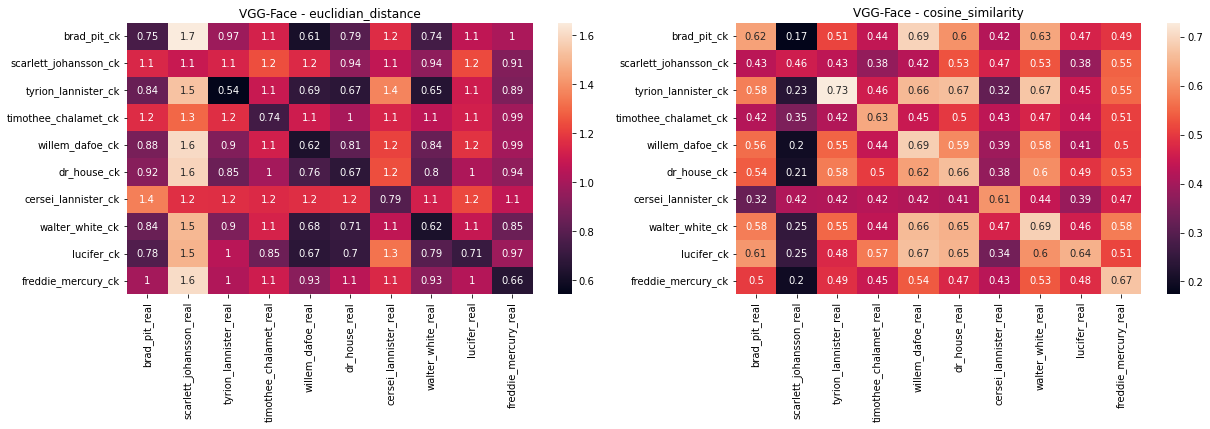

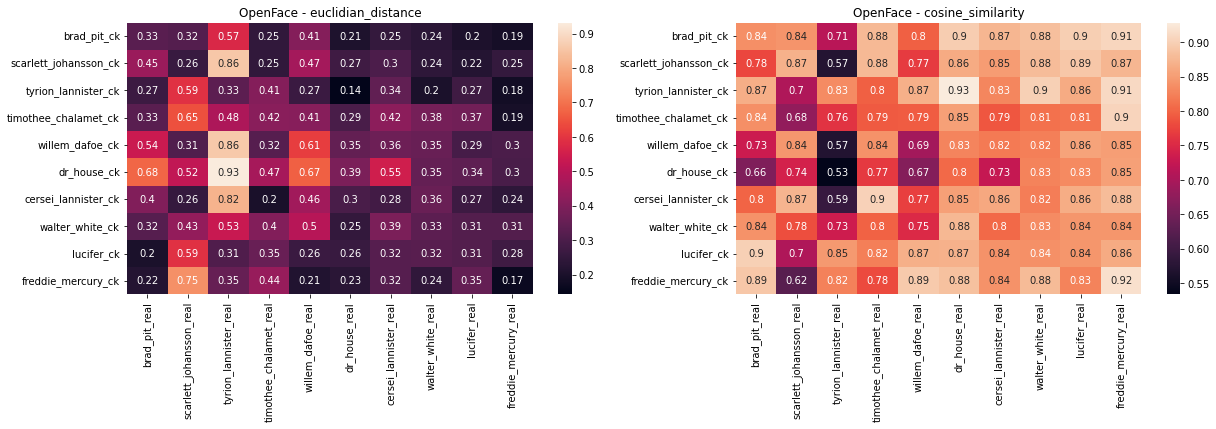

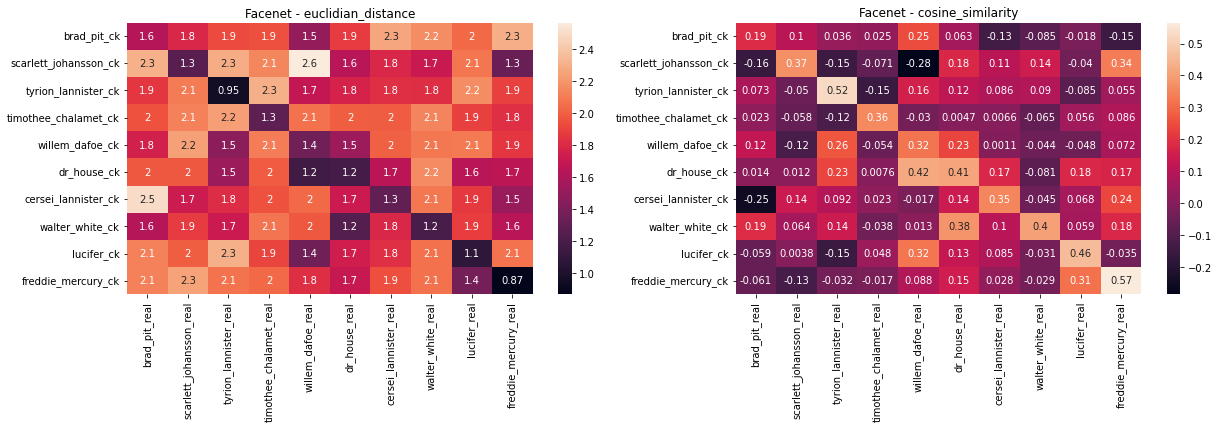

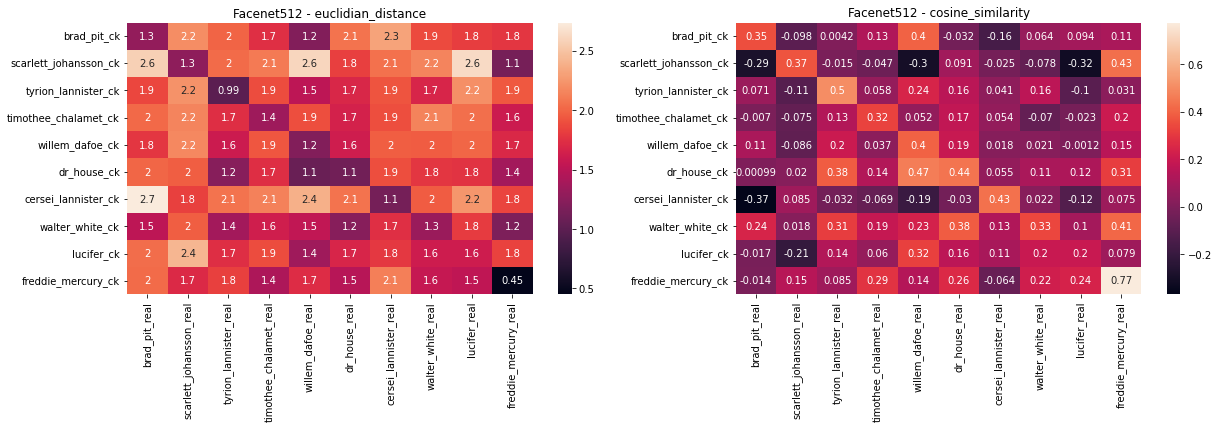

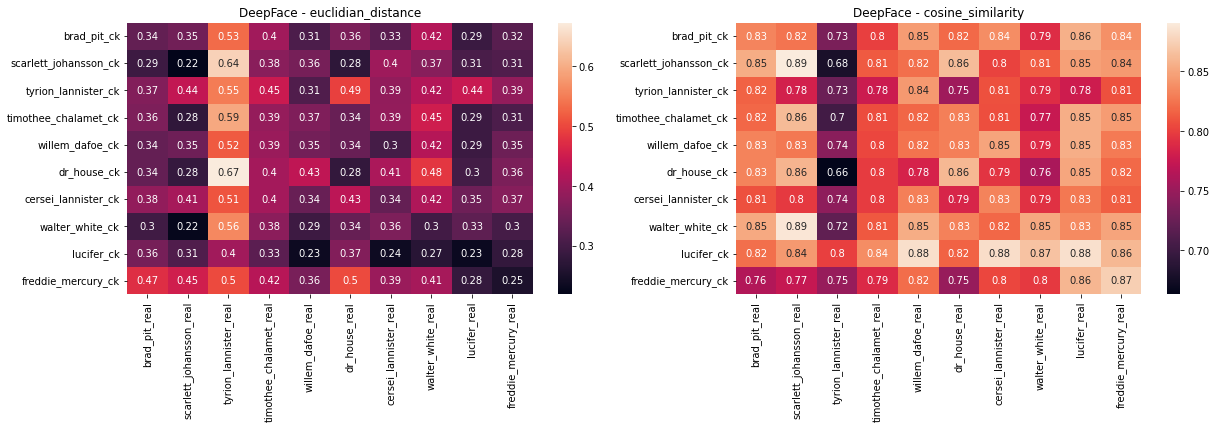

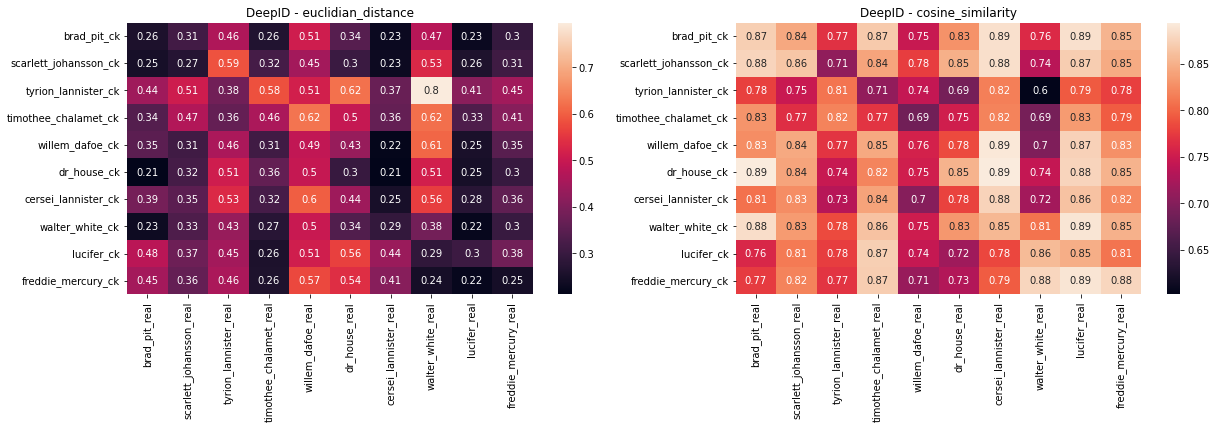

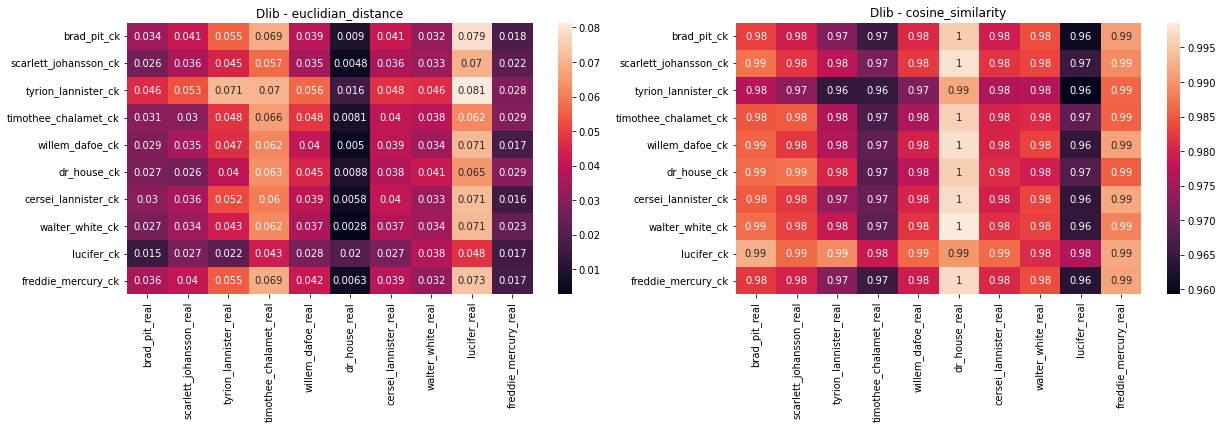

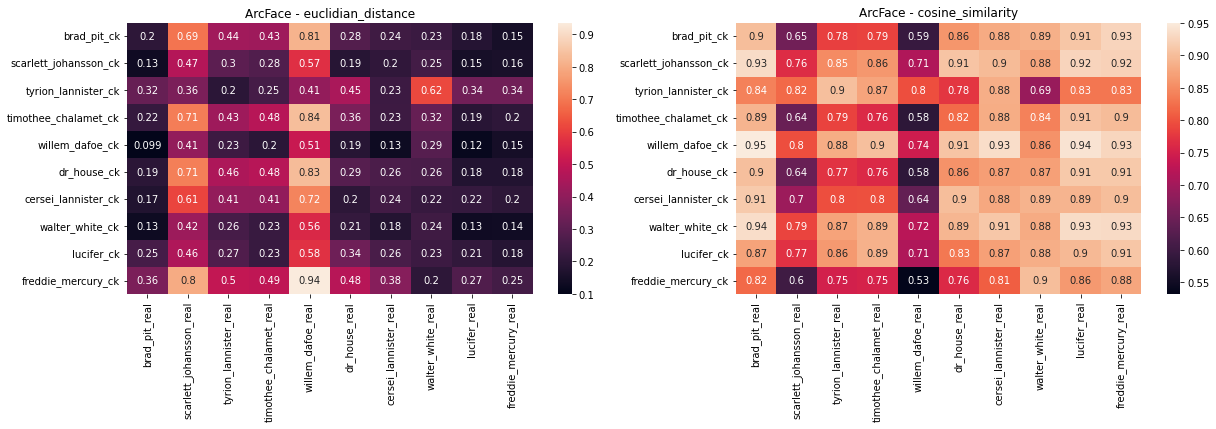

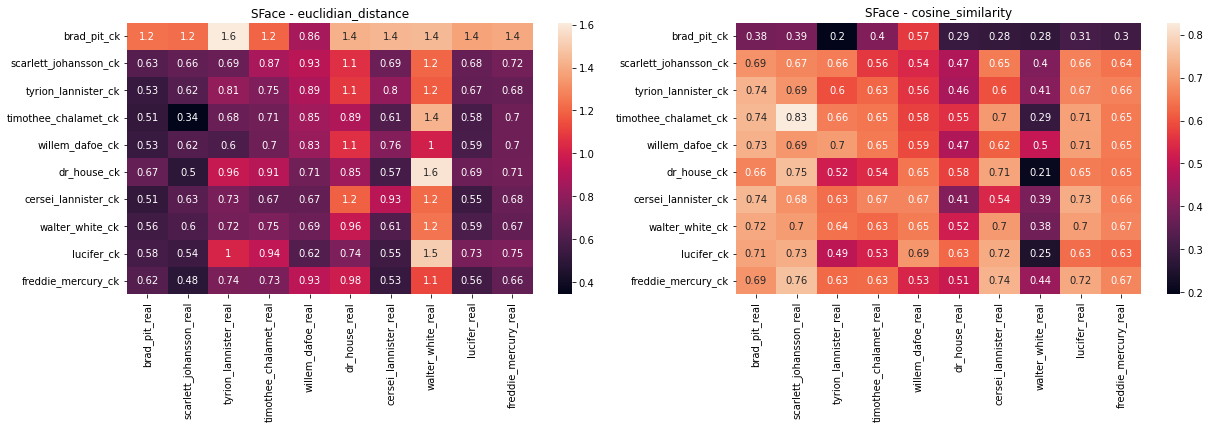

In [9]:
import numpy as np 
from sklearn.preprocessing import normalize

def cosine_similarity(features1, features2) -> np.ndarray:
    """
    features1, features2: [#samples, #dims]
    """
    f1 = normalize(features1)
    f2 = normalize(features2)
    return f1 @ f2.T

def euclidian_distance(features1, features2) -> np.ndarray:
    """
    features1, features2: [#samples, #dims]
    """
    f1 = normalize(features1)
    f2 = normalize(features2)
    return np.sum((f1[:, None, ...] - f2[None, ...]) ** 2, axis=-1)

metrics = [euclidian_distance, cosine_similarity]

for model, (ck_embeddings, rl_embeddings) in embeddings.items():
    plt.figure(figsize=(20, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        result = metric(np.array(ck_embeddings), np.array(rl_embeddings))
        plt.title(f"{model} - {metric.__name__}")
        sns.heatmap(result, annot=True, xticklabels=real_names, yticklabels=ck_names)
    plt.show()